# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [107]:
# Import libraries

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, GRU
import tensorflow as tf

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [ ]:
# Define a function to load data and aggregate them

def loadAndAggreateData(sourceDir):
    dataFrames = []
    for file in os.listdir(sourceDir):
        if file.endswith('.csv'): 
            filePath = os.path.join(sourceDir, file) # Get the full file path
            df = pd.read_csv(filePath)
            df['StockName'] = os.path.splitext(file)[0].split('_')[0] # Add a column for stock name
            dataFrames.append(df)
    
    combindeDf = pd.concat(dataFrames, ignore_index=True) # Concat all the dataframes List into single dataframe
    return combindeDf
    

In [109]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
sourceDir = "RNN_Stocks_Data"
sourceDf = loadAndAggreateData(sourceDir)


In [110]:
# View specifics of the data

sourceDf.head()

Date   Open   High    Low  Close   Volume  Name StockName
0  2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN      AMZN
1  2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN      AMZN
2  2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN      AMZN
3  2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN      AMZN
4  2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN      AMZN

In [111]:
sourceDf['StockName'].value_counts()

StockName
IBM      3020
AMZN     3019
MSFT     3019
GOOGL    3019
Name: count, dtype: int64

In [112]:
sourceDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       12077 non-null  object 
 1   Open       12076 non-null  float64
 2   High       12077 non-null  float64
 3   Low        12076 non-null  float64
 4   Close      12077 non-null  float64
 5   Volume     12077 non-null  int64  
 6   Name       12077 non-null  object 
 7   StockName  12077 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 754.9+ KB


In [113]:
sourceDf.describe()

Open          High           Low         Close        Volume
count  12076.000000  12077.000000  12076.000000  12077.000000  1.207700e+04
mean     227.387118    229.422254    225.203189    227.380960  1.671763e+07
std      236.938260    238.568485    234.981015    236.851101  2.570572e+07
min       15.200000     15.620000     14.870000     15.150000  2.542560e+05
25%       54.930000     55.660000     54.425000     55.210000  3.124704e+06
50%      158.795000    160.410000    157.355000    158.880000  5.445269e+06
75%      281.405000    284.500000    278.610000    281.510000  1.802087e+07
max     1204.880000   1213.410000   1191.150000   1195.830000  5.910786e+08

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [114]:
# Handle Missing Values
sourceDf.isnull().sum()

Date         0
Open         1
High         0
Low          1
Close        0
Volume       0
Name         0
StockName    0
dtype: int64

In [115]:
sourceDf1 = sourceDf.dropna() # Drop rows with missing values

In [116]:
sourceDf1.isnull().sum() # Check if there are still any missing values

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Name         0
StockName    0
dtype: int64

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

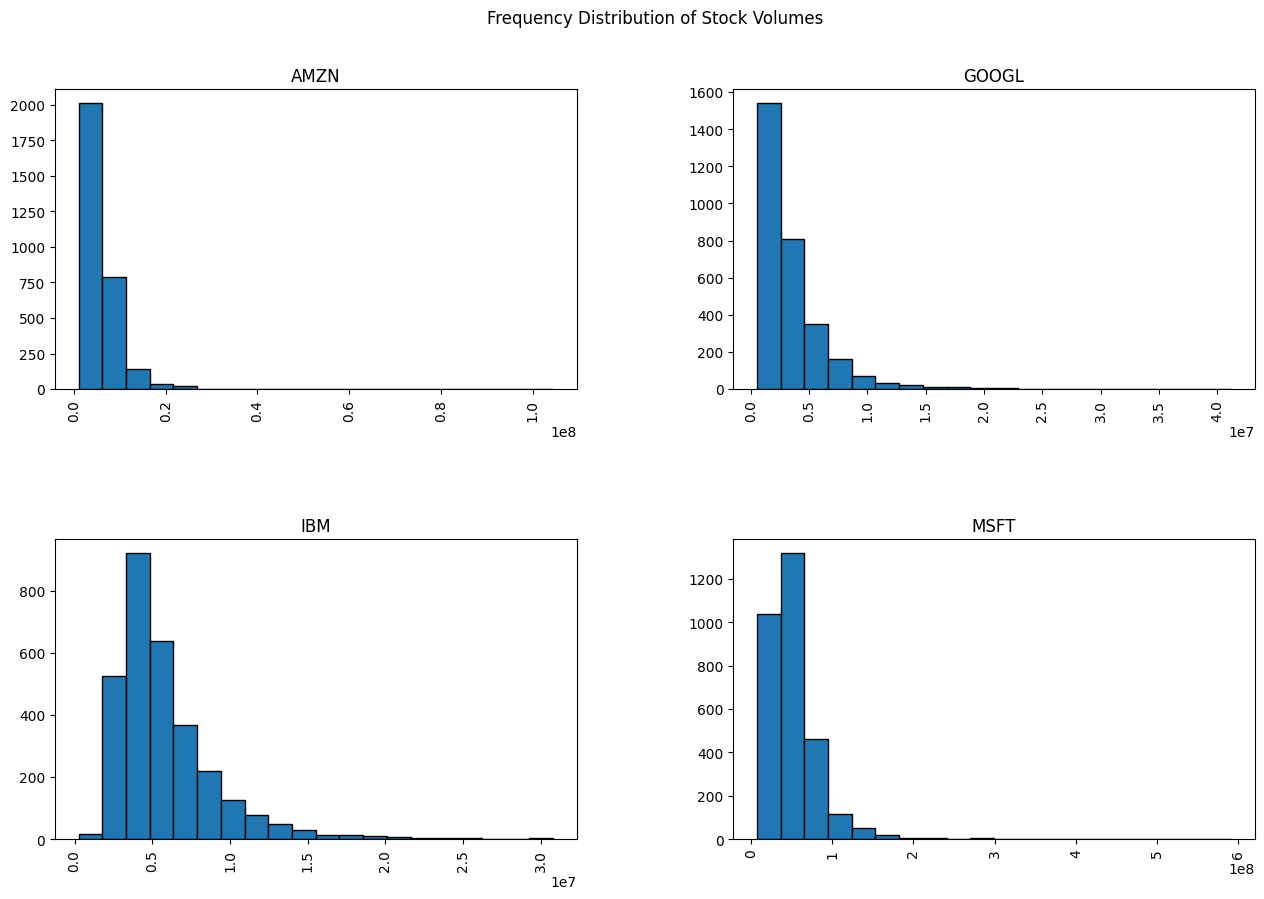

In [117]:
# Frequency distribution of volumes
sourceDf1.hist(column='Volume', by='StockName', bins=20, edgecolor='black', figsize=(15, 10))
plt.suptitle('Frequency Distribution of Stock Volumes')
plt.show()

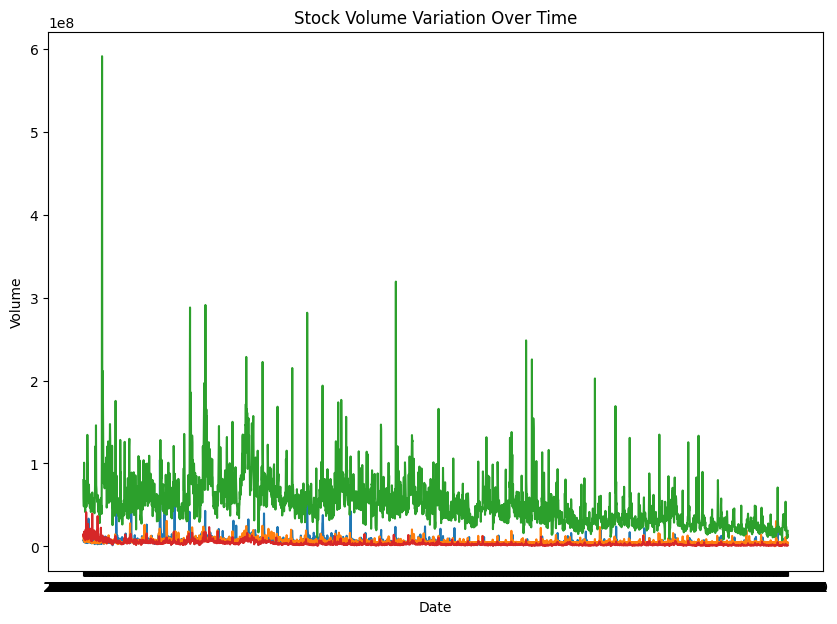

In [118]:
# Stock volume variation over time
plt.figure(figsize=(10, 7))
for stock in sourceDf1['StockName'].unique():
    stockData = sourceDf1[sourceDf1['StockName'] == stock]
    plt.plot(stockData['Date'], stockData['Volume'], label=stock)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Stock Volume Variation Over Time')
plt.show()



#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

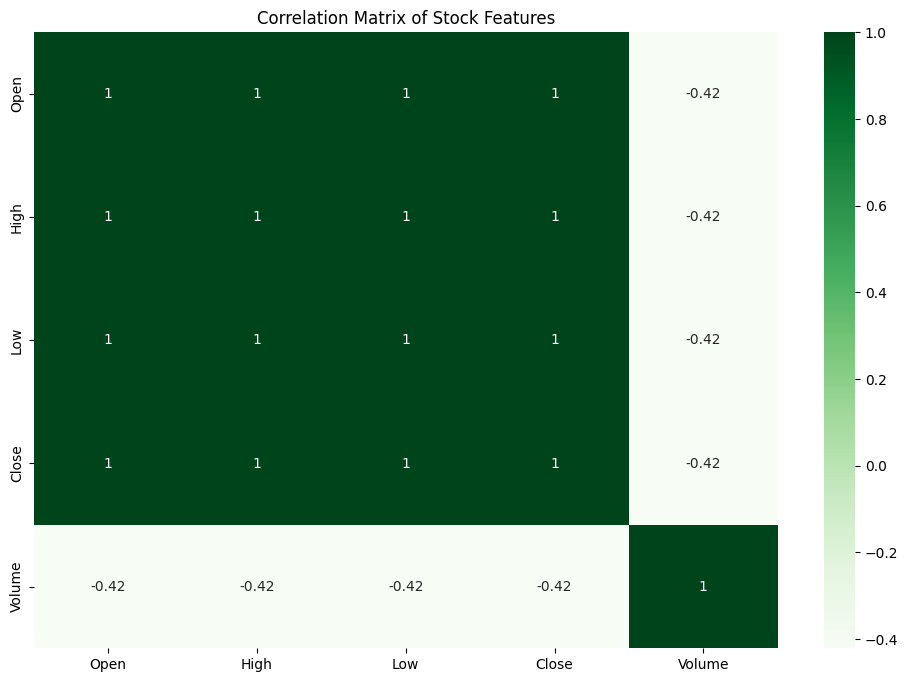

In [119]:
# Analyse correlations
corrMatrix = sourceDf1.select_dtypes(include=['number']).corr()  # Calculate the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corrMatrix, annot=True, cmap='Greens')
plt.title('Correlation Matrix of Stock Features')
plt.show()


### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [120]:
# Define a function that divides the data into windows and generates target variable values for each window
def divideIntoWindows(data, windowSize, stepSize, targetNames):
    X, y = [], []
    targetColumns = ['Open', 'High', 'Low', 'Close', 'Volume'] 
    stocksData = data[data['StockName'].isin(targetNames)]  # Filter data for the target stock names
    for i in range(0, len(stocksData) - windowSize-1, stepSize):
        window = stocksData.iloc[i:i + windowSize]
        XWindow = window[targetColumns].values  # Extract the target columns for the window
        yWindow = stocksData.iloc[i + windowSize + 1][['Close']].values
        X.append(XWindow)
        y.append(yWindow)
    return np.array(X), np.array(y)

In [121]:
targetNames = ['MSFT', 'GOOGL']  # Stocks of Microsoft and Google
windowSize = 60  # Size of the window
stepSize = 5  # Step size for moving the window
X, y = divideIntoWindows(sourceDf1, windowSize, stepSize, targetNames)
# Check the shape of the generated data
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1196, 60, 5)
Shape of y: (1196, 1)


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [122]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows
def scaleWindowedData(X, y):
    XScaler = MinMaxScaler()
    yScaler = MinMaxScaler()

    # Reshape for scaling
    numWindows, windowSize, numOfFeatures = X.shape
    XReshaped = X.reshape(-1, numOfFeatures)

    # Fit and transform X using partial fit
    XScaler.partial_fit(XReshaped)
    XScaled = XScaler.transform(XReshaped)
    XScaled = XScaled.reshape(numWindows, windowSize, numOfFeatures)

    # Fit and transform y
    yScaler.partial_fit(y)
    yScaled = yScaler.transform(y)

    return XScaled, yScaled, XScaler, yScaler


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [123]:
# Define a function to create input and output data points from the master DataFrame
def splitData(sourceData, windowSize, stepSize, targetNames, splitRatio=0.7):
    # Divide the data into windows and generate target variable values
    X, y = divideIntoWindows(sourceData, windowSize, stepSize, targetNames)
    # Scale the windowed data
    XScaled, yScaled, XScaler, yScaler = scaleWindowedData(X, y)
    # Split the data into training and testing sets
    XTrain, XTest, yTrain, yTest = train_test_split(XScaled, yScaled, train_size=splitRatio, random_state=42)
    return XTrain, XTest, yTrain, yTest, XScaler, yScaler


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

#### Daily Trend

/var/folders/yd/nd90kgx9607bb_l11wjrdqkh0000gn/T/ipykernel_859/4049334129.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sourceDf1['Date'] = pd.to_datetime(sourceDf1['Date'])  # Convert to datetime format


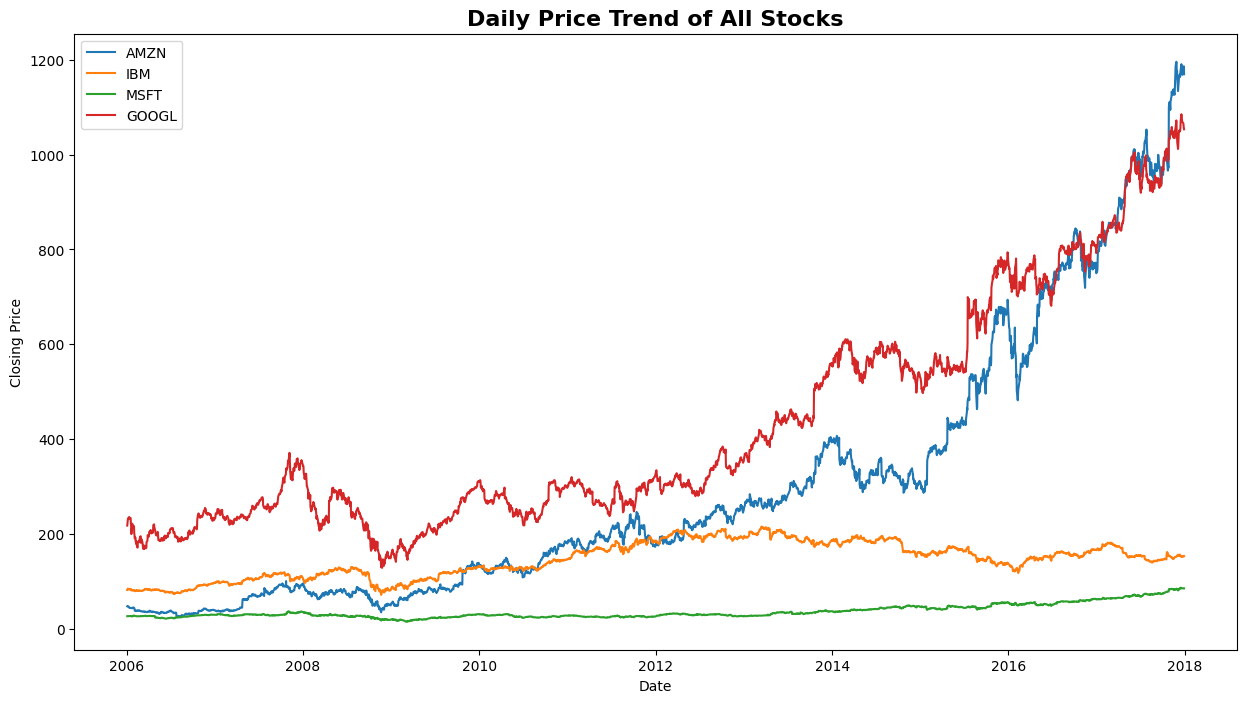

In [124]:
# Checking for patterns in different sequence lengths
# Daily Trend
sourceDf1['Date'] = pd.to_datetime(sourceDf1['Date'])  # Convert to datetime format
sourceDf2 = sourceDf1.set_index('Date')  # Set Date as index

plt.figure(figsize=(15, 8))
for stockName in sourceDf2['StockName'].unique():
    stockData = sourceDf2[sourceDf2['StockName'] == stockName]
    plt.plot(stockData.index, stockData['Close'], label=stockName)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Price Trend of All Stocks', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.legend()
plt.show()


#### Weekly Trend

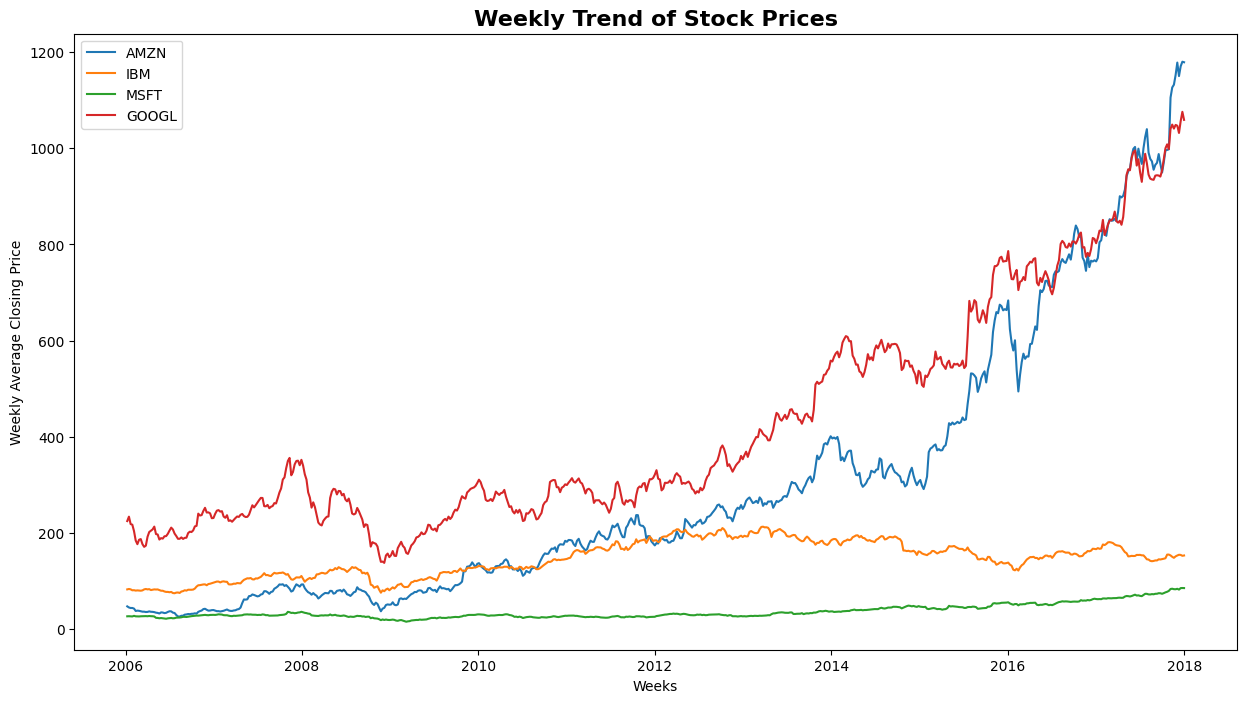

In [125]:

plt.figure(figsize=(15, 8))
for stockName in sourceDf2['StockName'].unique():
    stockData = sourceDf2[sourceDf2['StockName'] == stockName]
    targetData = stockData['Close']
    weeklyTrendData = targetData.resample('W').mean()  # Resample to weekly frequency and calculate mean
    plt.plot(weeklyTrendData.index, weeklyTrendData.values, label=stockName)
plt.xlabel('Weeks')
plt.ylabel('Weekly Average Closing Price')
plt.title('Weekly Trend of Stock Prices', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.legend()
plt.show()

#### Monthly Trend

/var/folders/yd/nd90kgx9607bb_l11wjrdqkh0000gn/T/ipykernel_859/3603860013.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthlyTrendData = targetDataMonthly.resample('M').mean()  # Resample to weekly frequency and calculate mean


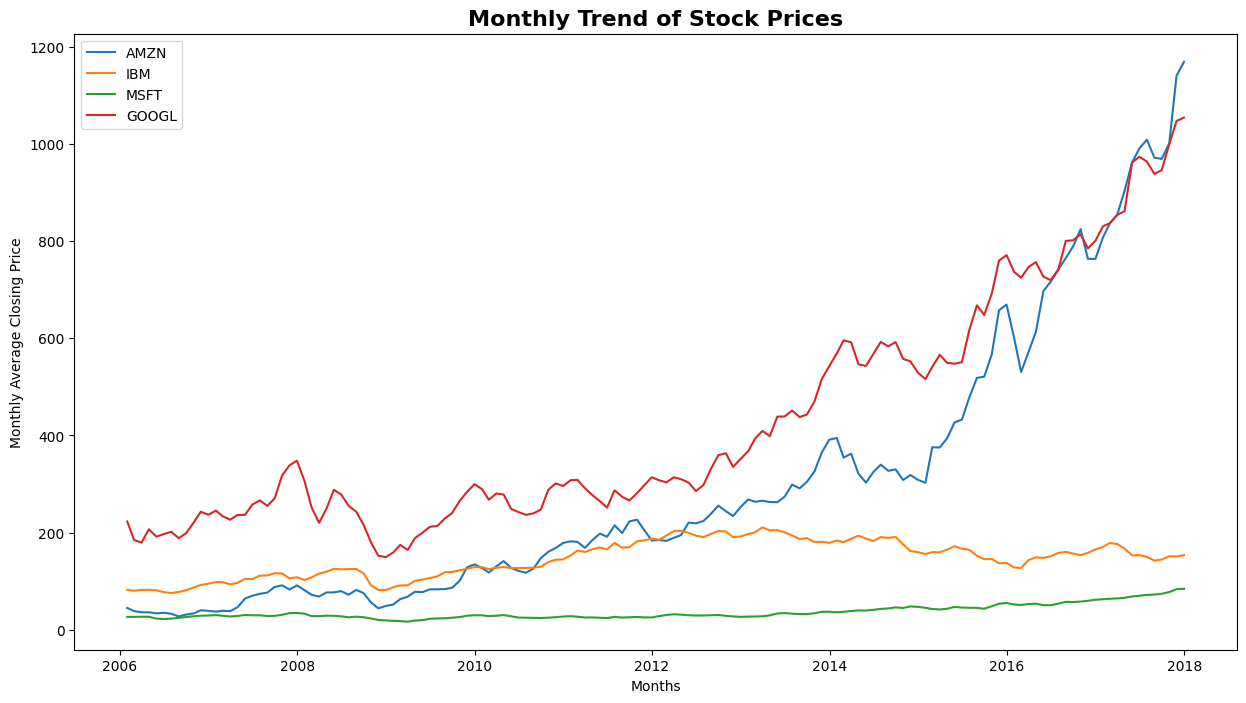

In [126]:

plt.figure(figsize=(15, 8))
for stockName in sourceDf2['StockName'].unique():
    stockData = sourceDf2[sourceDf2['StockName'] == stockName]
    targetDataMonthly = stockData['Close']
    monthlyTrendData = targetDataMonthly.resample('M').mean()  # Resample to weekly frequency and calculate mean
    plt.plot(monthlyTrendData.index, monthlyTrendData.values, label=stockName)
plt.xlabel('Months')
plt.ylabel('Monthly Average Closing Price')
plt.title('Monthly Trend of Stock Prices', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.legend()
plt.show()

#### Quarterly

/var/folders/yd/nd90kgx9607bb_l11wjrdqkh0000gn/T/ipykernel_859/1884085294.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterlyTrendData = targetDataQuarterly.resample('Q').mean()  # Resample to weekly frequency and calculate mean


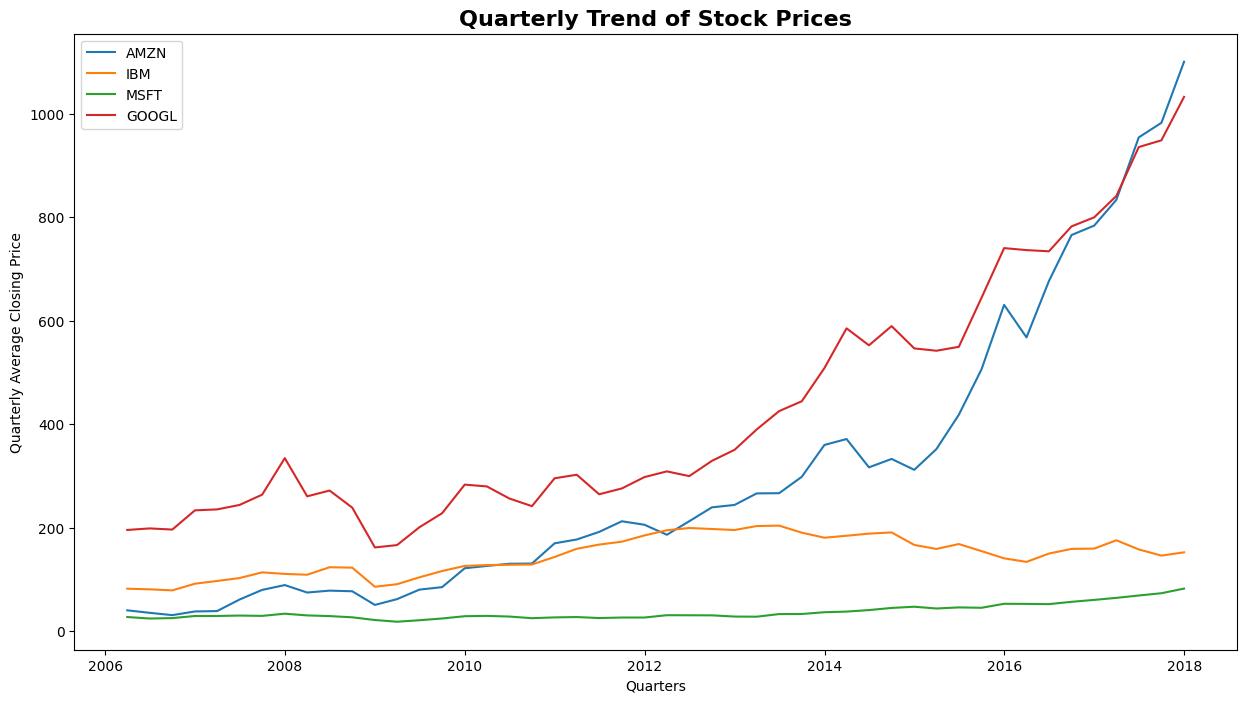

In [127]:

plt.figure(figsize=(15, 8))
for stockName in sourceDf2['StockName'].unique():
    stockData = sourceDf2[sourceDf2['StockName'] == stockName]
    targetDataQuarterly = stockData['Close']
    quarterlyTrendData = targetDataQuarterly.resample('Q').mean()  # Resample to weekly frequency and calculate mean
    plt.plot(quarterlyTrendData.index, quarterlyTrendData.values, label=stockName)
plt.xlabel('Quarters')
plt.ylabel('Quarterly Average Closing Price')
plt.title('Quarterly Trend of Stock Prices', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.legend()
plt.show()

#### Based on the trends above, daily & 30-Day period graphs do not show stable trend. Even though 60-Day trend is little better, Quarterly trend is more stable and consistent. Hence, going with 90 Day window size. For maximum data utilization, we will use the step size as 1.

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [ ]:
# Create data instances from the master data frame using decided window size and window stride
XTrain, XTest, yTrain, yTest, XScaler, yScaler = splitData(sourceData=sourceDf2, windowSize=90, stepSize=1, targetNames=['MSFT'])

In [129]:
# Check the number of data points generated
print("Number of Samples for Training:", len(XTrain))
print("Number of Samples for Testing:", len(XTest))


Number of Samples for Training: 2049
Number of Samples for Testing: 879


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [130]:
# Check if the datasets are compatible inputs to neural networks
print("Shape of XTrain:", XTrain.shape)
print("Shape of yTrain:", yTrain.shape)
print("Shape of XTest:", XTest.shape)
print("Shape of yTest:", yTest.shape)

Shape of XTrain: (2049, 90, 5)
Shape of yTrain: (2049, 1)
Shape of XTest: (879, 90, 5)
Shape of yTest: (879, 1)


In [131]:
# Verify the data types of the datasets
print("Data type of XTrain:", XTrain.dtype)
print("Data type of yTrain:", yTrain.dtype)
print("Data type of XTest:", XTest.dtype)
print("Data type of yTest:", yTest.dtype)

Data type of XTrain: float64
Data type of yTrain: float64
Data type of XTest: float64
Data type of yTest: float64


In [132]:
print("*"*30)
print("Sample Data XTrain:")
print(XTrain[0][:10, :5])
print("*"*30)

print("*"*30)
print("Sample Data yTrain:")
print(yTrain[0])
print("*"*30)

print("*"*30)
print("Sample Data XTest:")
print(XTest[0][:10, :5])
print("*"*30)

print("*"*30)
print("Sample Data yTest:")
print(yTest[0])
print("*"*30)

******************************
Sample Data XTrain:
[[0.23317575 0.2285754  0.23598655 0.23277545 0.06249418]
 [0.23442714 0.22913189 0.23444507 0.23040446 0.06019376]
 [0.22928254 0.22648859 0.23388453 0.2334728  0.03730677]
 [0.23220245 0.2278798  0.23500561 0.23082287 0.04036801]
 [0.22733593 0.22328881 0.23136211 0.22914923 0.04953163]
 [0.22719689 0.22927101 0.22954036 0.23584379 0.05251916]
 [0.23692992 0.24276572 0.24075112 0.2474198  0.08843086]
 [0.24429922 0.24040067 0.24663677 0.24476987 0.03320171]
 [0.23998888 0.24137451 0.24649664 0.24714086 0.03097098]
 [0.24068409 0.23553144 0.24299327 0.23821478 0.05490834]]
******************************
******************************
Sample Data yTrain:
[0.32845188]
******************************
******************************
Sample Data XTest:
[[0.39988877 0.4015025  0.40751121 0.40781032 0.02674253]
 [0.40517241 0.40164162 0.39868274 0.40655509 0.04970458]
 [0.40656285 0.40734558 0.40863229 0.40571827 0.05544442]
 [0.41087319 0.411

## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [133]:
# Create a function that creates a simple RNN model according to the model configuration arguments
def createSimpleRNNModel(inputShape, numOfUnits=50, dropoutRate=0.2, optimizer='adam', activation='tanh'):
    model = Sequential()
    model.add(SimpleRNN(numOfUnits, input_shape=inputShape, activation=activation))     
    model.add(Dense(1))  # Output layer for regression

    model.compile(optimizer=optimizer, loss='mse')
    
    return model

In [134]:
# Model Summary of the Simple RNN Model
inputShape = XTrain.shape[1:]
model = createSimpleRNNModel(inputShape)
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,851 (11.14 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [135]:
# Perform hyperparameter tuning and print the top 5 configurations by validation loss
def findTopRNNConfigs(XTrain, yTrain, XTest, yTest, numOfUnitsList=[50, 100], dropoutRateList=[0.2, 0.3], epochs=10):
    results = []
    bestModel = None
    bestValLoss = float('inf')
    
    for numOfUnits in numOfUnitsList:
        for dropoutRate in dropoutRateList:
            print(f"Training model with units: {numOfUnits} and dropout rate: {dropoutRate}")
            model = createSimpleRNNModel(inputShape=XTrain.shape[1:], numOfUnits=numOfUnits, dropoutRate=dropoutRate)
            history = model.fit(XTrain, yTrain, epochs=epochs, batch_size=32, validation_data=(XTest, yTest), verbose=0)
            val_loss = model.evaluate(XTest, yTest, verbose=0)
            print(f"Validation Loss: {val_loss}")
            
            # Store the configuration and validation loss
            results.append({
                'numOfUnits': numOfUnits,
                'dropoutRate': dropoutRate,
                'val_loss': val_loss,
                'model': model
            })

            # Check if this is the best model so far
            if val_loss < bestValLoss:
                bestValLoss = val_loss
                bestModel = model

    
    # Sort results by validation loss
    results = sorted(results, key=lambda x: x['val_loss'])
    
    # Print the top 5 configurations
    print("\nTop 5 Configurations by Validation Loss:")
    for i, result in enumerate(results[:5]):
        print(f"Rank {i+1}: Units={result['numOfUnits']}, Dropout={result['dropoutRate']}, Validation Loss={result['val_loss']}")
    
    # Make predictions with the best model
    yPred = bestModel.predict(XTest)
    yPred = yScaler.inverse_transform(yPred)  # Inverse transform to get actual values
    yTestActual = yScaler.inverse_transform(yTest)  # Inverse transform to get actual values

    # Calculate evaluation metrics
    mse = mean_squared_error(yTestActual, yPred)
    r2 = r2_score(yTestActual, yPred)
    mae = mean_absolute_error(yTestActual, yPred)   

    print(f"\nBest Model Evaluation:\nMSE: {mse}\nR2: {r2}\nMAE: {mae}")

    return results[:5], bestModel

# Run the function to find the top configurations
topConfigs, bestModel = findTopRNNConfigs(XTrain, yTrain, XTest, yTest, numOfUnitsList=[50, 100], dropoutRateList=[0.2, 0.3], epochs=10)

Training model with units: 50 and dropout rate: 0.2
Validation Loss: 0.0005895866197533906
Training model with units: 50 and dropout rate: 0.3
Validation Loss: 0.00041655628592707217
Training model with units: 100 and dropout rate: 0.2
Validation Loss: 0.0007505217799916863
Training model with units: 100 and dropout rate: 0.3
Validation Loss: 0.0003008610801771283

Top 5 Configurations by Validation Loss:
Rank 1: Units=100, Dropout=0.3, Validation Loss=0.0003008610801771283
Rank 2: Units=50, Dropout=0.3, Validation Loss=0.00041655628592707217
Rank 3: Units=50, Dropout=0.2, Validation Loss=0.0005895866197533906
Rank 4: Units=100, Dropout=0.2, Validation Loss=0.0007505217799916863
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Best Model Evaluation:
MSE: 1.5466931708273732
R2: 0.9927623205829962
MAE: 0.9491745834437386


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [136]:
# Make predictions with the best model
yPred = bestModel.predict(XTest)
yPred = yScaler.inverse_transform(yPred)  # Inverse transform to get actual values for Y Pred
yTestActual = yScaler.inverse_transform(yTest)  # Inverse transform to get actual values for Y Test Actuals

# Calculate evaluation metrics
mse = mean_squared_error(yTestActual, yPred)
r2 = r2_score(yTestActual, yPred)
mae = mean_absolute_error(yTestActual, yPred)   
RMSE = np.sqrt(mean_squared_error(yTestActual, yPred))
print(f"\nRMSE: {RMSE}")
print(f"\nBest Model Evaluation:\nMSE: {mse}\nR2: {r2}\nMAE: {mae}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

RMSE: 1.2436611961572868

Best Model Evaluation:
MSE: 1.5466931708273732
R2: 0.9927623205829962
MAE: 0.9491745834437386


Plotting the actual vs predicted values

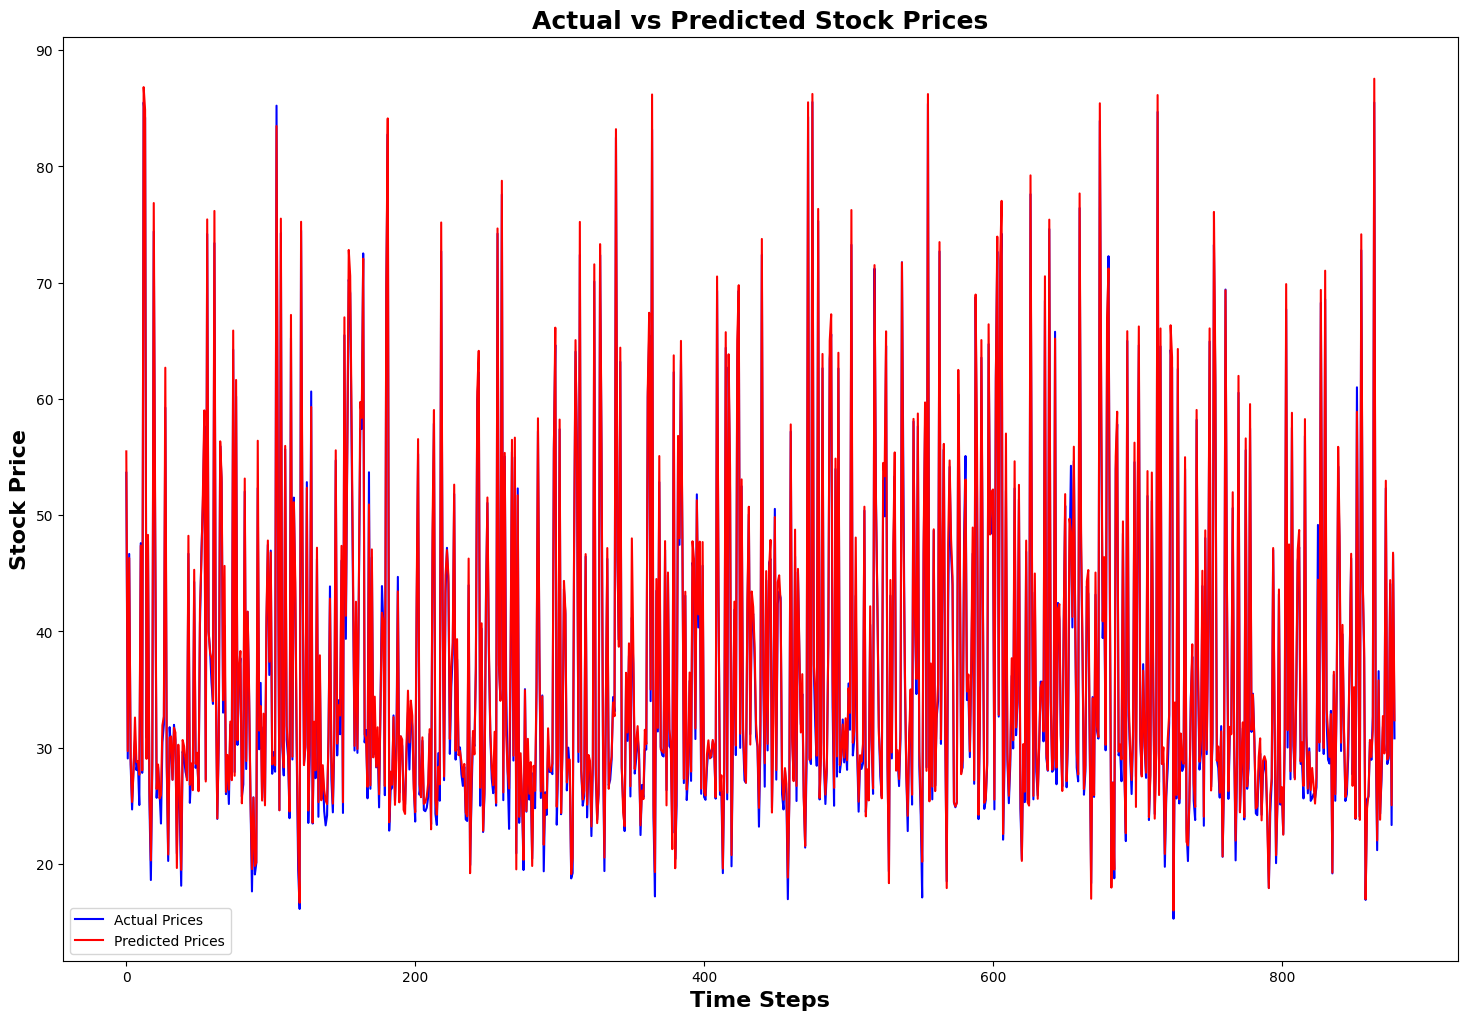

In [137]:
# Predict on the test data and plot
plt.figure(figsize=(18, 12))
plt.plot(yTestActual, label='Actual Prices', color='blue')
plt.plot(yPred, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.xlabel('Time Steps', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Stock Price', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.legend()
plt.show()


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [138]:
# # Define a function to create a model and specify default values for hyperparameters

def advancedRNNModel(inputShape, numOfUnits=50, dropoutRate=0.2, optimizer='adam', activation='tanh', recurrentDropout=0.2):
    model = Sequential()
    model.add(GRU(numOfUnits, input_shape=inputShape, activation=activation, dropout=dropoutRate, recurrent_dropout=recurrentDropout))  # First RNN layer
    model.add(Dense(1))  # Output layer for regression

    model.compile(optimizer=optimizer, loss='mse')
    return model
     

In [139]:
inputShape = XTrain.shape[1:]
model = advancedRNNModel(inputShape=inputShape)
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 50)             │         8,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,601 (33.60 KB)

 Trainable params: 8,601 (33.60 KB)

 Non-trainable params: 0 (0.00 B)

In [140]:
# Model with hyperparameter tuning
model = advancedRNNModel(inputShape=inputShape, numOfUnits=100, dropoutRate=0.3, optimizer='adam', activation='tanh', recurrentDropout=0.3)
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 100)            │        32,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,201 (125.79 KB)

 Trainable params: 32,201 (125.79 KB)

 Non-trainable params: 0 (0.00 B)

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Perform hyperparameter tuning for the GRU model
def tuneGRUModel(XTrain, yTrain, XTest, yTest, numOfUnitsList=[50, 100], dropoutRateList=[0.2, 0.3], recurrentDropoutList=[0.2, 0.3], epochs=10):
    results = []
    bestModel = None
    bestValLoss = float('inf')
    
    for numOfUnits in numOfUnitsList:
        for dropoutRate in dropoutRateList:
            for recurrentDropout in recurrentDropoutList:
                print(f"Training GRU model with units: {numOfUnits}, dropout rate: {dropoutRate}, recurrent dropout: {recurrentDropout}")
                model = advancedRNNModel(inputShape=XTrain.shape[1:], numOfUnits=numOfUnits, dropoutRate=dropoutRate, recurrentDropout=recurrentDropout)
                history = model.fit(XTrain, yTrain, epochs=epochs, batch_size=32, validation_data=(XTest, yTest), verbose=0)
                val_loss = model.evaluate(XTest, yTest, verbose=0)
                print(f"Validation Loss: {val_loss}")
                
                # Store the configuration and validation loss
                results.append({
                    'numOfUnits': numOfUnits,
                    'dropoutRate': dropoutRate,
                    'recurrentDropout': recurrentDropout,
                    'val_loss': val_loss,
                    'model': model
                })

                # Check if this is the best model so far
                if val_loss < bestValLoss:
                    bestValLoss = val_loss
                    bestModel = model

    # Sort results by validation loss
    results = sorted(results, key=lambda x: x['val_loss'])
    
    # Print the top 5 configurations
    print("\nTop 5 Configurations by Validation Loss:")
    for i, result in enumerate(results[:5]):
        print(f"Rank {i+1}: Units={result['numOfUnits']}, Dropout={result['dropoutRate']}, Recurrent Dropout={result['recurrentDropout']}, Validation Loss={result['val_loss']}")

    return results[:5], bestModel

# Run the function to find the top configurations
topConfigsGRU, bestGRUModel = tuneGRUModel(XTrain, yTrain, XTest, yTest, numOfUnitsList=[50, 100], dropoutRateList=[0.2, 0.3], recurrentDropoutList=[0.2, 0.3], epochs=10)

Training GRU model with units: 50, dropout rate: 0.2, recurrent dropout: 0.2
Validation Loss: 0.003046802245080471
Training GRU model with units: 50, dropout rate: 0.2, recurrent dropout: 0.3
Validation Loss: 0.0037339446134865284
Training GRU model with units: 50, dropout rate: 0.3, recurrent dropout: 0.2
Validation Loss: 0.007379768416285515
Training GRU model with units: 50, dropout rate: 0.3, recurrent dropout: 0.3
Validation Loss: 0.0033899787813425064
Training GRU model with units: 100, dropout rate: 0.2, recurrent dropout: 0.2
Validation Loss: 0.007829125970602036
Training GRU model with units: 100, dropout rate: 0.2, recurrent dropout: 0.3
Validation Loss: 0.006544125732034445
Training GRU model with units: 100, dropout rate: 0.3, recurrent dropout: 0.2
Validation Loss: 0.010142887942492962
Training GRU model with units: 100, dropout rate: 0.3, recurrent dropout: 0.3
Validation Loss: 0.008867376483976841

Top 5 Configurations by Validation Loss:
Rank 1: Units=50, Dropout=0.2, R

In [142]:
# Find an optimal configuration
optimalConfig = topConfigsGRU[0]
print(f"\nOptimal Configuration: Units={optimalConfig['numOfUnits']}, Dropout={optimalConfig['dropoutRate']}, Recurrent Dropout={optimalConfig['recurrentDropout']}, Validation Loss={optimalConfig['val_loss']}")



Optimal Configuration: Units=50, Dropout=0.2, Recurrent Dropout=0.2, Validation Loss=0.003046802245080471


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [143]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
# Resetting the session to clear the previous model
tf.keras.backend.clear_session()

bestGRUModel = advancedRNNModel(inputShape=inputShape, numOfUnits=optimalConfig['numOfUnits'], dropoutRate=optimalConfig['dropoutRate'], recurrentDropout=optimalConfig['recurrentDropout'])
bestGRUModel.summary()

history = bestGRUModel.fit(XTrain, yTrain, epochs=50, batch_size=32, validation_data=(XTest, yTest), verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         8,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,601 (33.60 KB)

 Trainable params: 8,601 (33.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0379 - val_loss: 0.0016
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0075 - val_loss: 0.0012
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0098 - val_loss: 0.0012
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0063 - val_loss: 9.8707e-04
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0056 - val_loss: 0.0015
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0056 - val_loss: 0.0021
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss:

In [144]:
# Compute the performance of the model on the testing data set
testLoss = bestGRUModel.evaluate(XTest, yTest, verbose=0)
print(f"Test Loss: {testLoss}")

Test Loss: 0.004024258349090815


Plotting the actual vs predicted values

In [145]:

# Predict on the test data
yPred = bestGRUModel.predict(XTest)
RMSE = np.sqrt(mean_squared_error(yTest, yPred))
print(f"RMSE: {RMSE}")
mse = mean_squared_error(yTest, yPred)
r2 = r2_score(yTest, yPred)
mae = mean_absolute_error(yTest, yPred)

print(f"Evaluation Metrics:\nMSE: {mse}\nR2: {r2}\nMAE: {mae}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE: 0.06343704375879904
Evaluation Metrics:
MSE: 0.004024258520855784
R2: 0.9031901920952138
MAE: 0.04980119167678479


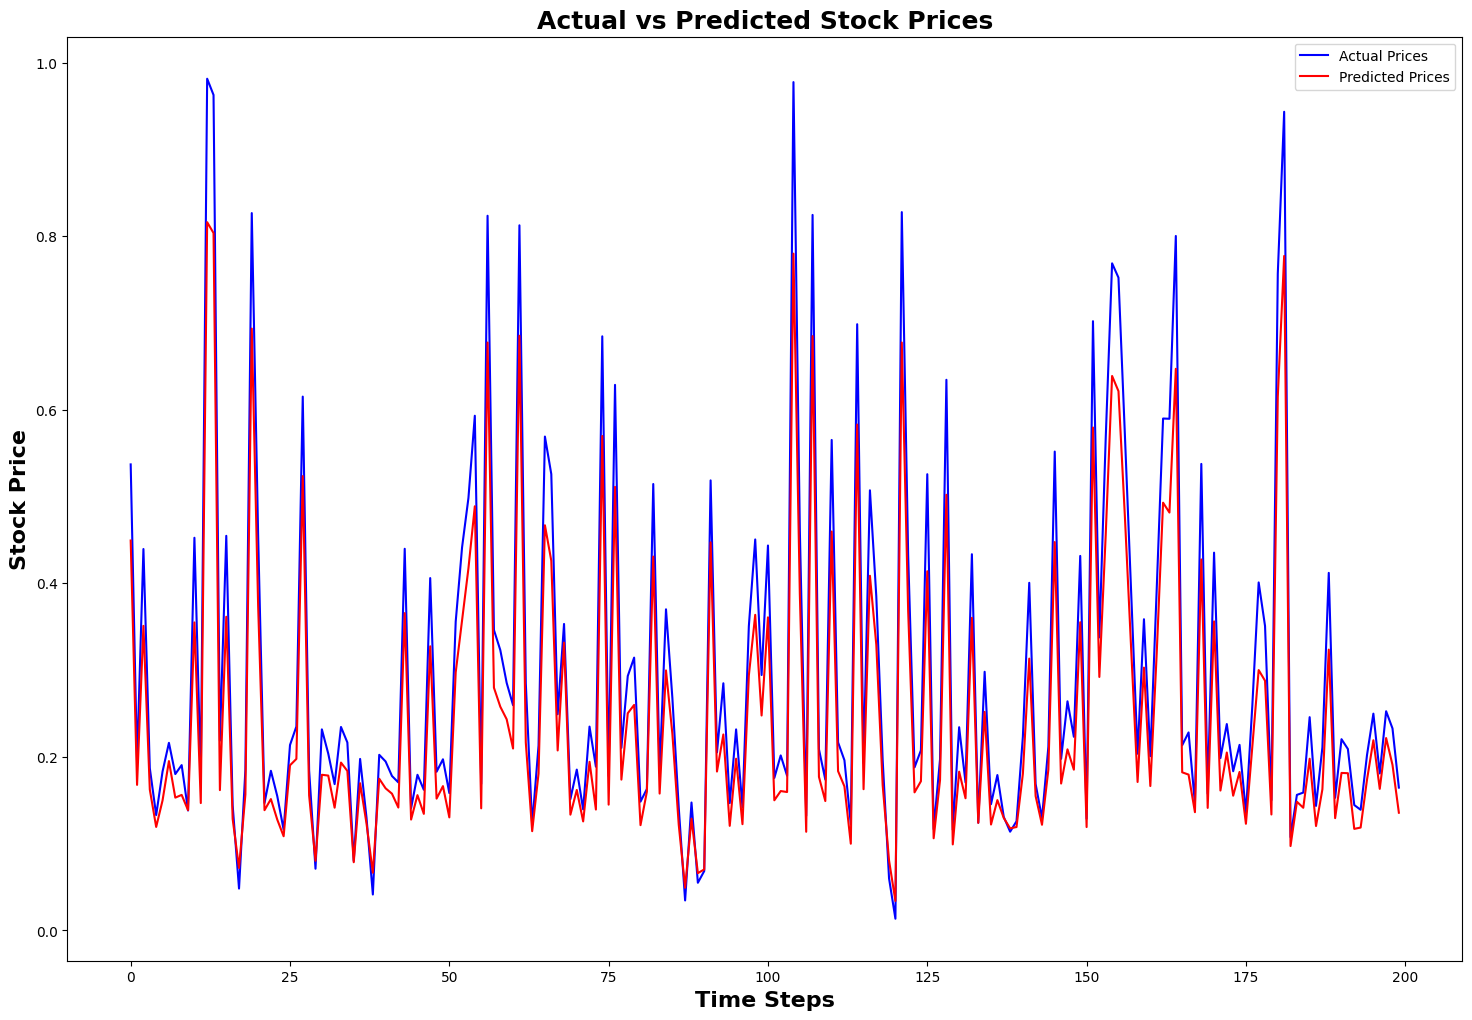

In [146]:
# Plot Actual vs Predicted values
plt.figure(figsize=(18, 12))
plt.plot(yTest[:200], label='Actual Prices', color='blue')
plt.plot(yPred[:200], label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.xlabel('Time Steps', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Stock Price', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.legend()
plt.show()


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [147]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [148]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [149]:
# Find an optimal configuration of simple RNN



In [150]:
# Find the best configuration



In [151]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [152]:
# Compute the performance of the model on the testing data set



In [153]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [154]:
# Find an optimal configuration of advanced RNN



In [155]:
# Find the best configuration



In [156]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [157]:
# Compute the performance of the model on the testing data set



In [158]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

### Models Built
- Simple RNN Model 
- Advanced GRU Model 

### Model Performance Comparison
| Evaluation Metric | Simple RNN | Advanced GRU | 
| ------------------|------------|--------------|
| RMSE              | 1.2436     | 0.0634       |
| MSE               | 1.5466     | 0.0040       |
| R2 Score          | 0.9927     | 0.9031       |
| MAE               | 0.9491     | 0.0498       |


### Insights
- MSE & RMSE has reduced significantly. Smaller RMSE indicates that the predictions are closer to the actual values, making it more reliable and accurate.
- R2 score measures how well the model explains the variance in the target variable. Even though R2 score is reduced in the Advanced model, it is still explaining more than 90% of the variance.
- MAE is significantly reduced for the Advanced model. This shows that Advanced model is far more effective in minimizing prediction errors.

### Conclusion
The Advanced GRU model built performs way better than the Simple RNN model in all evaluation metrics. This showcases that Advanced models are better than simple RNN models when it comes to Time series prediction problems.